In [82]:
import brightway2 as bw
import bw2calc as bc
import bw2io as bi
import numpy as np
import pandas as pd
import bw2analyzer as ba
import plotly.express as px


In [83]:
# if 'ei38-teaching' not in bw.projects:
bi.restore_project_directory("/srv/data/projects/ecoinvent38.tar.gz")
    
bw.projects.set_current('ei38-teaching')

Restoring project backup archive - this could take a few minutes...


In [84]:
bw.databases

Databases dictionary with 2 object(s):
	biosphere3
	ei 3.8 cutoff

In [85]:
imp = bi.ExcelImporter("./data/inputs/lci_solarpv_huimin_masterthesis_combined.xlsx")
imp.apply_strategies()
imp.match_database("ei 3.8 cutoff", fields=('name','unit','location'))
#imp.match_database("ecoinvent_remind_SSP2-Base_2020", fields=('name','unit','location','reference product'))
imp.match_database(fields=('name', 'unit', 'location'))
imp.statistics()
imp.write_excel(only_unlinked=True)
list(imp.unlinked)

imp.write_database()


Extracted 1 worksheets in 0.02 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 6.83 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
18 datasets
386 exchanges
0 unlinked exchanges
  
Wrote matching file to:
/home/jupyter

In [88]:
bw.databases

Databases dictionary with 4 object(s):
	biosphere3
	ei 3.8 cutoff
	energy_moeschberg_ref
	solar_huimin

In [86]:
if "foreground" in bw.databases:
    del bd.databases["foreground"]
    
foreground_importer = bw.ExcelImporter("./data/inputs/lci_moeschberg_ref.xlsx")
foreground_importer.apply_strategies()
foreground_importer.match_database("biosphere3", fields=("name", "unit", "categories"))
foreground_importer.match_database("ei 3.8 cutoff", fields=("name", "unit", "location"))
foreground_importer.statistics()
foreground_importer.write_database()

Extracted 1 worksheets in 0.00 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 6.92 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
5 datasets
18 exchanges
0 unlinked exchanges
  
Title: Writing activities to SQLite3 da

In [68]:
foreground=bw.Database('energy_moeschberg_ref')

In [87]:
ei = bw.Database("ei 3.8 cutoff")

In [89]:
fu=[act for act in foreground if 'opera' in act['name']][0]
fu

'energy demand, operational, Hotel Moeschberg' (unit, CH, None)

In [90]:
ipcc=('IPCC 2013', 'climate change', 'GWP 100a')

In [91]:
adp = ('EF v3.0', 'material resources: metals/minerals', 'abiotic depletion potential (ADP): elements (ultimate reserves)')

In [92]:
lca=bw.LCA({fu:1},ipcc)
lca.lci()
lca.lcia()
lca.score

9310.091231235312

In [79]:
def parent(df):
    parent=[]
    for i in df.index:    
        if df.at[i,'Niveau']==0:
            parent.append('')
        elif df.at[i,'Niveau']==1:
            y=i
            while df.at[y,'Niveau']!=0:
                y=y-1
            parent.append(df.at[y,'Activities'])
        elif df.at[i,'Niveau']==3:
            y=i
            while df.at[y,'Niveau']!=2:
                y=y-1
            parent.append(df.at[y,'Activities'])
        elif df.at[i,'Niveau']==2:
            y=i
            while df.at[y,'Niveau']!=1:
                y=y-1
            parent.append(df.at[y,'Activities'])
    df['Parent']=parent
    return df

def LCA_treemap(names, values, niveau, activity, lcia_method, lca_obj=None, total_score=None, amount=1, level=0, max_level=3, cutoff=1e-2):
    
    if lca_obj is None:
        lca_obj = bc.LCA({activity: amount}, lcia_method)
        lca_obj.lci()
        lca_obj.lcia()
        total_score = lca_obj.score
    elif total_score is None:
        raise ValueError
    else:
        lca_obj.redo_lcia({activity: amount})
        if abs(lca_obj.score) >= abs(total_score * cutoff):
            names.append(activity["name"])    
            values.append(lca_obj.score/total_score*100)
            niveau.append(level)
    if level < max_level:
        for exc in activity.technosphere(): 
            LCA_treemap(
                names=names,
                values=values,
                niveau=niveau,
                activity=exc.input, 
                lcia_method=lcia_method, 
                lca_obj=lca_obj, 
                total_score=total_score, 
                amount=amount * exc['amount'], 
                level=level + 1, 
                max_level=max_level, 
                cutoff=cutoff
            )      
   
    return  parent(pd.DataFrame({'Activities':names,'Niveau':niveau,'Values':values}))

def LCA_plot_treemap(df):
    composants=[]
    ss_composants=[]
    ss_ss_composants=[]
    values=[]
    for i in df.index:
        if df.at[i,"Niveau"]==3:
            values.append(df.at[i,'Values'])
            ss_ss_composants.append(df.at[i,'Activities'])
            ss_composants.append(df.at[i,'Parent'])
            y=i
            while df.at[y,'Activities']!=df.at[i,'Parent']:
                y=y-1
            composants.append(df.at[y,'Parent'])
    return pd.DataFrame({'Composants':composants,'Sous composants':ss_composants,'Sous sous composants':ss_ss_composants,'Values':values})

In [80]:
if True:
    names,values,niveau=['Eng demand'], [100], [0]
    df_Treemap=LCA_treemap(names,values,niveau,fu,ipcc,amount=1, level=0, max_level=3,cutoff=.0001)
    Treemap=LCA_plot_treemap(df_Treemap)
    fig = px.treemap(Treemap, path=[px.Constant('Eng demand'),'Composants', 'Sous composants', 'Sous sous composants'],values='Values',width=1000, height=600,
                  color='Values',
                  color_continuous_scale='reds')
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.update_traces(hovertemplate=None, hoverinfo='value')
    fig.write_html("./data/outputs/LCA_Contribution_Treemap.htm")

In [93]:
import pandas as pd
def fraction_scoreLCA(name_activity, share_of_activity, activity, lcia_method, lca_obj=None, total_score=None, amount=1, level=0, max_level=3, cutoff=1e-2):
    
    if lca_obj is None:
        lca_obj = bc.LCA({activity: amount}, lcia_method)
        lca_obj.lci()
        lca_obj.lcia()
        total_score = lca_obj.score
    elif total_score is None:
        raise ValueError
    else:
        lca_obj.redo_lcia({activity: amount})
        if abs(lca_obj.score) >= abs(total_score * cutoff):
            name_activity.append(activity["name"])    
            share_of_activity.append(lca_obj.score/total_score*100)    
    
    if level < max_level:
        for exc in activity.technosphere(): 
            fraction_scoreLCA(
                name_activity=name_activity,
                share_of_activity=share_of_activity,
                activity=exc.input, 
                lcia_method=lcia_method, 
                lca_obj=lca_obj, 
                total_score=total_score, 
                amount=amount * exc['amount'], 
                level=level + 1, 
                max_level=max_level, 
                cutoff=cutoff
            )      
    return name_activity, share_of_activity


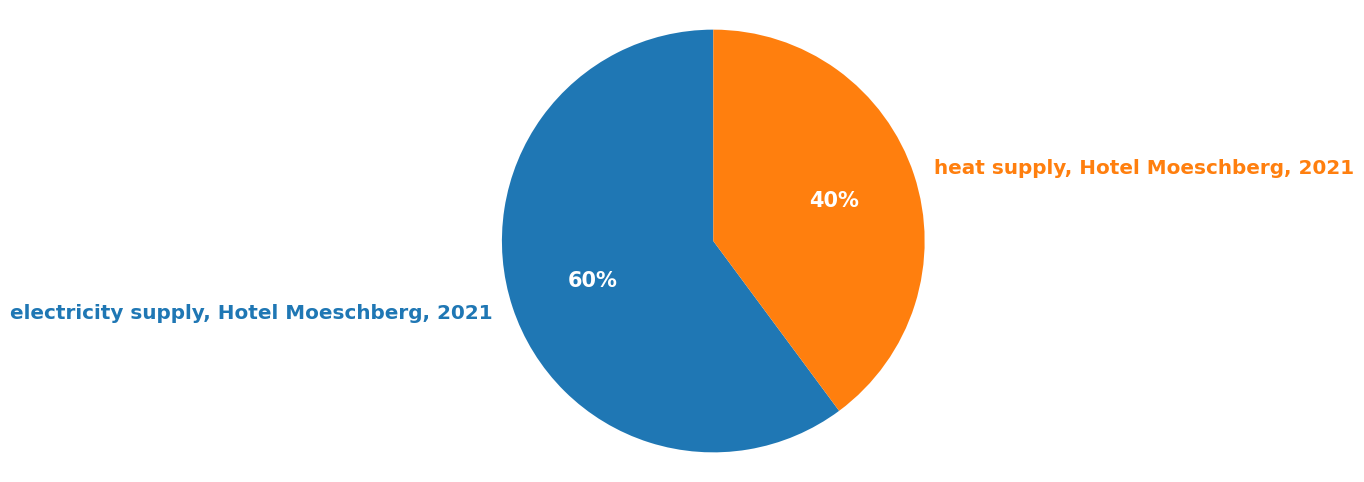

In [103]:
import matplotlib.pyplot as plt


name_CC, share_CC =[], []
name_CC,share_CC=fraction_scoreLCA(name_CC, share_CC,fu,adp,amount=1, level=0, max_level=1,cutoff=.01)

res_CC=pd.DataFrame(index=['CC'],columns=name_CC,data=np.array(share_CC)[np.newaxis]).sort_index(axis=1) #newaxis oermet de transformer un vecteur ligne en colonne
figure,axes=plt.subplots(figsize=(6,6))

patches, texts, pcts =axes.pie(res_CC.T['CC'],autopct='%1.0f%%', labels = res_CC.T.index,startangle = 90,
                                  textprops={'size': 'x-large'})
for i, patch in enumerate(patches):
    texts[i].set_color(patch.get_facecolor())
plt.setp(pcts, color='white',weight='bold', fontsize=15)
plt.setp(texts, fontweight=800)
plt.axis('equal')
figure.patch.set_facecolor('white')
# res_CC.T.plot(kind='pie',ax=axes,subplots=True,autopct='%1.0f%%',startangle = 90,legend=True)
plt.axis('equal')
figure.patch.set_facecolor('white')
plt.savefig('./data/outputs/ContributionPhase_ADP.png', dpi=300, bbox_inches='tight')

In [40]:
bw.databases

Databases dictionary with 3 object(s):
	biosphere3
	ei 3.8 cutoff
	energy_moeschberg

In [99]:
elec = [act for act in bw.Database('energy_moeschberg_ref') if 'electricity supply' in act['name']][0]
elec

'electricity supply, Hotel Moeschberg, 2021' (kilowatt hour, CH, None)

In [100]:
name_CC, share_CC =[], []
name_CC,share_CC=fraction_scoreLCA(name_CC, share_CC,elec,adp,amount=1, level=0, max_level=1,cutoff=.01)

res_CC=pd.DataFrame(index=['CC'],columns=name_CC,data=np.array(share_CC)[np.newaxis]).sort_index(axis=1) #newaxis oermet de transformer un vecteur ligne en colonne
res_CC
# figure,axes=plt.subplots(figsize=(6,6))


# res_CC.T.plot(kind='pie',ax=axes,subplots=True,autopct='%1.0f%%',startangle = 90, labeldistance=None,legend=True)
# plt.axis('equal')
# figure.patch.set_facecolor('white')
# plt.savefig('./data/outputs/ContributionPhase_heatSupply.png', dpi=300, bbox_inches='tight')

,"electricity production, photovoltaic, 3kWp slanted-roof installation, multi-Si, panel, mounted","electricity supply, Energie Grosshoechstetten AG, 2021, guarantees of origin"
CC,92.930577,7.069421
